# Evalutating Geneformer in zero-shot setting

In [16]:
%load_ext autoreload
%autoreload 2

In [1]:
import os 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["HF_ENDPOINT"]="https://hf-mirror.com"

import logging
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import data, cell_embeddings, model_output
from sc_foundation_evals.helpers.custom_logging import log
from sc_foundation_evals.utils import eval_scib_metrics
log.setLevel(logging.INFO)

## Setting up variables

Define some variables, that we will rely on later, starting with paths and run configs.

In [2]:
geneformer_data = "../../data/weights/Geneformer"
# path to the pre-trained model, can work with the huggingface model hub
# i.e. ctheodoris/Geneformer
model_dir = os.path.join(geneformer_data, "default/12L")
# path to dictionaries in geneformer repo
dict_dir = os.path.join(geneformer_data, "dicts")

Alternatively to the code above, you can also use the snippet below, using the copy of the Genefomerme repository.

```python
repo_dir = "/path/to/repository/of/Geneformer"
model_dir = os.path.join(repo_dir)
dict_dir = os.path.join(repo_dir, "geneformer")
```

In [3]:
# batch_size depends on available GPU memory
batch_size = 24
# output_dir is the path to which the results should be saved
output_dir = "../../output/geneformer/12L/"
# path to where we will store the embeddings and other evaluation outputs
model_out = os.path.join(output_dir, "model_outputs")
# if you can use multithreading specify num_workers, -1 means use all available
num_workers = -1

Data paths and configs.

I will be using the Pancreas dataset as an example, as described in the scGPT_zero-shot notebook.

In [4]:
# specify the path to anndata object
in_dataset_path = "../../data/datasets/pancreas_scib.h5ad"
# dataset_name is inferred from in_dataset_path
dataset_name = os.path.basename(in_dataset_path).split(".")[0]
# specify the path for the output of the pre-processing
preprocessed_path = f"../../data/datasets/geneformer/{dataset_name}/"
# create the preprocessed path if it does not exist
os.makedirs(preprocessed_path, exist_ok=True)
# in which column in adata.obs are gene names stored? if they are in index, the index will be copied to a column with this name
gene_col = "gene_symbols"
# batch column found in adata.obs
batch_col = "batch"
# where are labels stored in adata.obs? 
label_col = "celltype" #"str_labels"
# where the raw counts are stored?
layer_key = "counts" #"X" 

## Loading model and data

In [6]:
geneform = gf.Geneformer_instance(save_dir = output_dir, 
                                  saved_model_path = model_dir,
                                  explicit_save_dir = True,
                                  num_workers = num_workers)

INFO     | 2024-06-05 16:26:12 | Using device cuda


In [7]:
geneform.load_pretrained_model()

INFO     | 2024-06-05 16:26:15 | Model successfully loaded from ../../data/weights/Geneformer/default/12L


Load them vocabulary and gene to Ensembl ID matching.

In [8]:
geneform.load_vocab(dict_dir)

To prepare the data, we need to preprocess it and then tokenize it. First, we create the input data objec.

In [9]:
input_data = data.InputData(adata_dataset_path = in_dataset_path)

INFO     | 2024-06-05 16:26:18 | Loading data from ../../data/datasets/pancreas_scib.h5ad


Then, we preprocess the data - match gene names and filter cells and genes. This will create a new adata, that will be saved in the `preprocessed_path` to a `.loom` or `.h5ad` file. Loom data seems to be causing more issues in this version of the Geneformer code, so I'll stick with this, but overall this should also work with adata format.

In [ ]:
input_data.preprocess_data(gene_col = gene_col,
                           model_type = "geneformer",
                           save_ext = "loom",
                           gene_name_id_dict = geneform.gene_name_id,
                           preprocessed_path = preprocessed_path)

Now, tokenizing the data. Preprocessing saves the data to a file, as the tokenizer expects to read it from drive. This will create a `dataset_name`.dataset directory with the tokenized data in the `preprocessed_path`. This will also read in the tokenized_data to the `geneform` object.

In [ ]:
geneform.tokenize_data(adata_path = os.path.join(preprocessed_path, 
                                                 f"{dataset_name}.loom"),
                       dataset_path = preprocessed_path,
                       cell_type_col = label_col)

If the data was already tokenized, we can just load it.

In [11]:
geneform.load_tokenized_dataset(os.path.join(preprocessed_path, f"{dataset_name}.dataset"))
input_data = data.InputData(adata_dataset_path = os.path.join(preprocessed_path, f"{dataset_name}.loom"))

INFO     | 2024-06-05 16:26:33 | Loading data from ../../data/datasets/geneformer/pancreas_scib/pancreas_scib.loom


In [12]:
input_data.adata.X.shape

(16382, 16388)

## Evaluating model outputs 
Geneformer: correlation of gene rank

scGPT: MSE of gene expression value

First, we will perform forward pass on the model and extract embeddings. We're interested with second to last layer, as per the instructions in the codebase of Geneformer [here](https://huggingface.co/ctheodoris/Geneformer/blob/main/geneformer/emb_extractor.py#L285). Using the argument `layer` we can refer to layers according to python logic (i.e. 0 is the embedding layer, 1 - first layer, 2 is the second layer, etc. and -1 is the last layer, etc.).

*Note:* If you get a CUDA out of memory error, you can try reducing the batch size. As a rule of thumb, try batch sizes of multiples of 8, to avoid potential issues with how approximations are handled in CUDA.

In [13]:
geneform.extract_embeddings(data = input_data,
                            batch_size = batch_size, 
                            layer = -2) # recommend use the 2nd to last layer 

Geneformer (extracting embeddings):   0%|          | 0/683 [00:00<?, ?it/s]

In [14]:
eval_pred = model_output.GeneExprPredEval(geneform, 
                                          output_dir = model_out)

In [15]:
eval_pred.evaluate(n_cells = 500,
                   save_rankings = True)

,correlation,mean_correlation
count,500.000000,500.000000
mean,0.563326,0.651940
std,0.118622,0.119835
min,0.172808,0.220977
25%,0.487987,0.535938
50%,0.546221,0.717222
75%,0.665748,0.754039
max,0.802809,0.823980


INFO     | 2023-12-05 15:07:41 | Subsetting to 100 cells


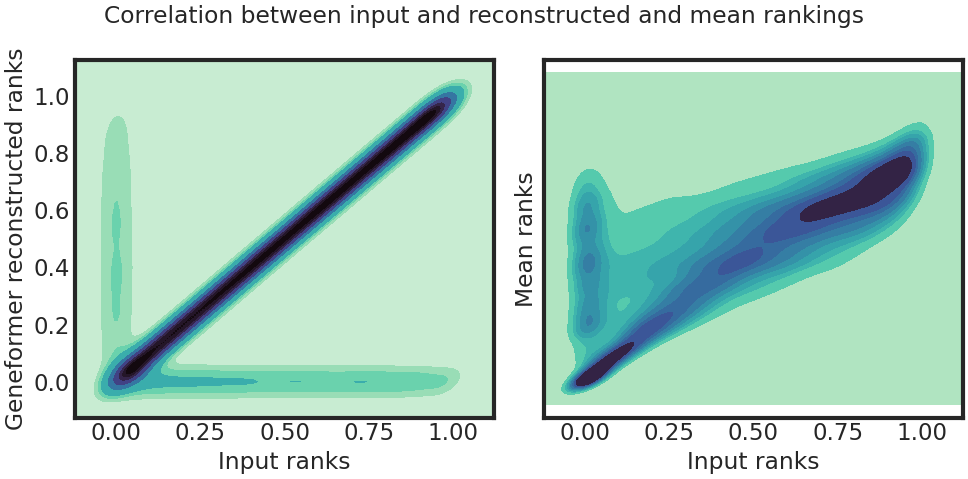

In [14]:
eval_pred.visualize(n_cells = 100, cmap = "mako_r")

# Evaluate the cell embeddings

First, creating cell embeddings evaluation object.

In [17]:
eval_ce = cell_embeddings.CellEmbeddingsEval(geneform,
                                             data = input_data,
                                             output_dir = model_out,
                                             label_key = label_col,
                                             batch_key = batch_col)

Then, evaluating the embeddings. Here, for speed we are subsetting the data to 1000 cells.

In [17]:
# with n_cells you can specify how much to subset the obs for
eval_ce.evaluate(n_cells = 1000, embedding_key = "geneformer")

WARNING  | 2024-05-27 14:28:53 | adata_ has 16382 cells. Taking a subset of 1000 cells.


,metric,label,value
0,NMI_cluster/label,celltype,0.091457
1,ARI_cluster/label,celltype,0.023780
2,ASW_label,celltype,0.323220
3,graph_conn,celltype,0.476560
4,ASW_batch,celltype,0.622801
5,ASW_label/batch,celltype,0.676177
6,PCR_batch,celltype,0.632932
7,avg_bio,celltype,0.146152


WARNING  | 2024-05-27 14:30:29 | adata_ has 16382 cells. Taking a subset of 7500 cells.
WARNING  | 2024-05-27 14:30:30 | More than 10 labels for celltype.The plots might be hard to read.


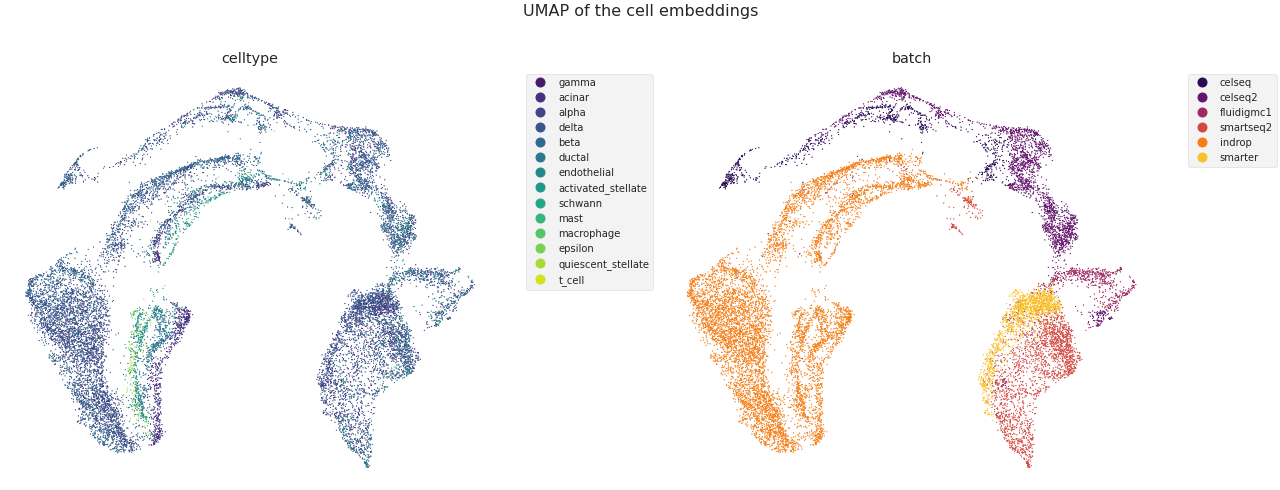

In [18]:
eval_ce.visualize(embedding_key = "geneformer")

In [14]:
adata = input_data.adata.copy()
adata.obsm["geneformer"].shape

(16382, 512)

In [ ]:
eval_scib_metrics(adata, batch_key=batch_col, label_key=label_col, embedding_key="geneformer")

# Reference mapping and transfer the annotations

In [18]:
import faiss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [94]:
ref_batch = ['indrop', 'celseq2', 'celseq']
adata.obs["is_ref"] = adata.obs["batch"].isin(ref_batch).astype("category")
adata.obs

,adata_order,batch,celltype,n_counts,n_genes,n_genes_by_counts,obs_names,size_factors,tech,total_counts,is_ref
0,D101_5,celseq,gamma,7217.966797,1857,1857,D101_5,0.028492,celseq,7217.966797,True
1,D101_43,celseq,gamma,11462.871094,3724,3724,D101_43,0.079348,celseq,11462.871094,True
2,D101_93,celseq,gamma,8234.897461,2261,2261,D101_93,0.037932,celseq,8234.897461,True
3,D102_4,celseq,gamma,9143.431641,2653,2653,D102_4,0.047685,celseq,9143.431641,True
4,D172444_23,celseq,gamma,8093.402344,2230,2230,D172444_23,0.038683,celseq,8093.402344,True
...,...,...,...,...,...,...,...,...,...,...,...
16377,Sample_1594,smarter,gamma,13117.564453,5842,5842,Sample_1594,1.000000,smarter,13117.564453,False
16378,Sample_1595,smarter,gamma,12656.491211,5196,5196,Sample_1595,1.000000,smarter,12656.491211,False
16379,Sample_1597,smarter,gamma,14825.818359,6356,6356,Sample_1597,1.000000,smarter,14825.818359,False
16380,Sample_1598,smarter,gamma,11100.341797,4170,4170,Sample_1598,1.000000,smarter,11100.341797,False


... storing 'batch' as categorical
... storing 'celltype' as categorical
... storing 'tech' as categorical


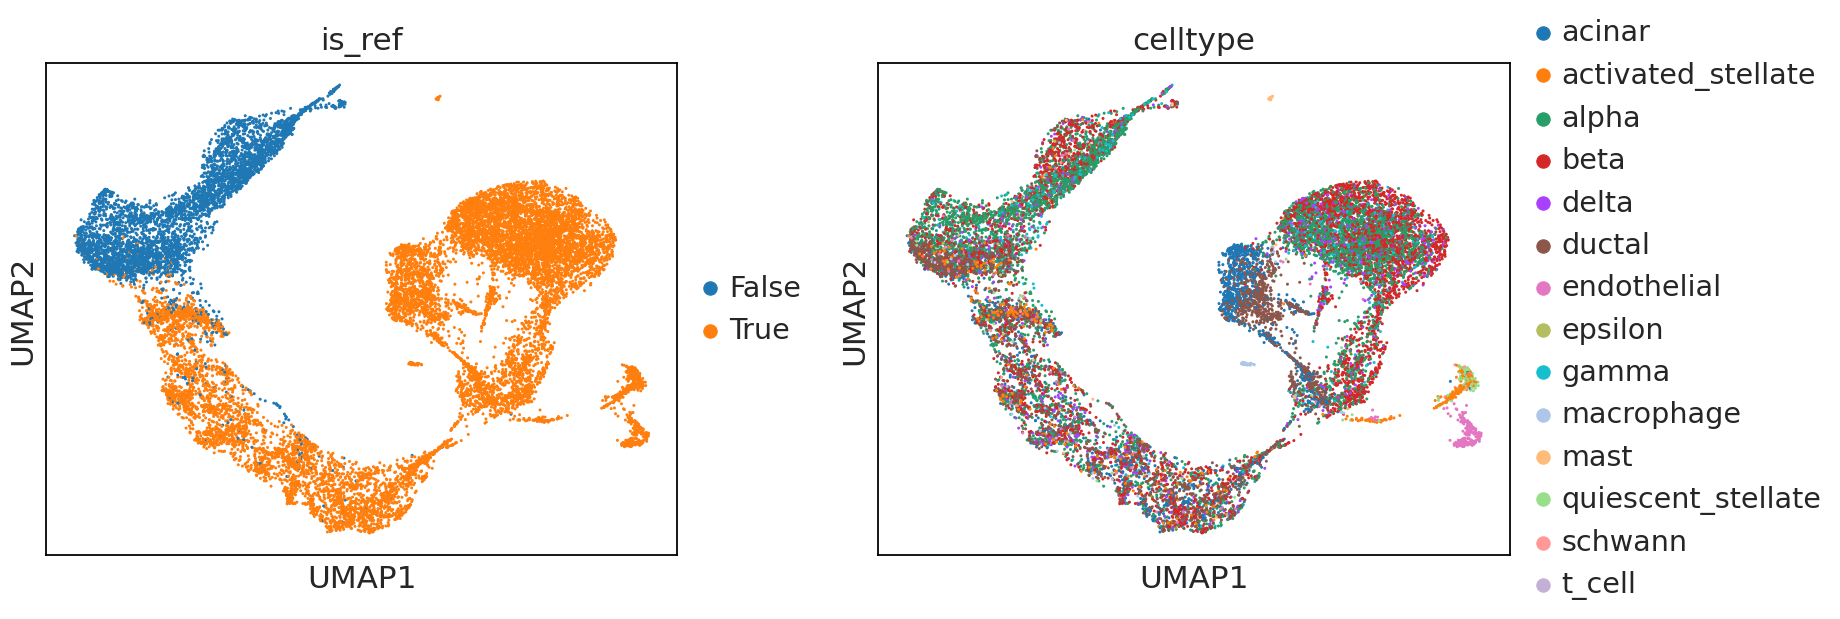

In [95]:
# calculate distance between cells, save in adata.obsp
sc.set_figure_params(facecolor="white", figsize=(5,4), transparent=True)
sc.pp.neighbors(adata, use_rep="geneformer")  # use_rep: any valid key in adata.obsm
# 将距离嵌入图中
sc.tl.umap(adata, min_dist = 0.3)
fig = sc.pl.umap(adata, color=["is_ref", "celltype"], wspace=0.2, return_fig=True, frameon=True)

fig.savefig("../../output/geneformer/12L/pancreas_2nd_last_layer.png")

In [96]:
ref_adata = adata[adata.obs["is_ref"]==True]
test_adata = adata[adata.obs["is_ref"]==False]

In [97]:
ref_cell_embeddings = ref_adata.obsm["geneformer"]
test_embed = test_adata.obsm["geneformer"]

k = 10  # number of neighbors

index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_embed, k)

idx_list=[i for i in range(test_embed.shape[0])]
preds = []
uncertainty = []
sim_list = distances
for k in idx_list:
    idx = labels[k]
    pred = ref_adata.obs[label_col][idx].value_counts()
    preds.append(pred.index[0]) # major voting
    uncertainty.append(1 - pred[0]/k)
gt = test_adata.obs[label_col].to_numpy()

# report uncertainty of reference mapping

#### 12L, emb_layer=-1 (the last layer)

In [26]:
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

{'accuracy': 0.24049513704686118,
 'precision': 0.12970160932301736,
 'recall': 0.16081318149718157,
 'macro_f1': 0.1156543636302719}

#### 12L, emb_layer=-2 (the 2nd to last layer)

In [98]:
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

{'accuracy': 0.2451370468611848,
 'precision': 0.08279374395217058,
 'recall': 0.11579445159551703,
 'macro_f1': 0.07839851406113096}

#### 6L, emb_layer=-2 (the 2nd to last layer)

In [78]:
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

{'accuracy': 0.20358090185676392,
 'precision': 0.09496168872310232,
 'recall': 0.10628386791805099,
 'macro_f1': 0.06789660779895898}

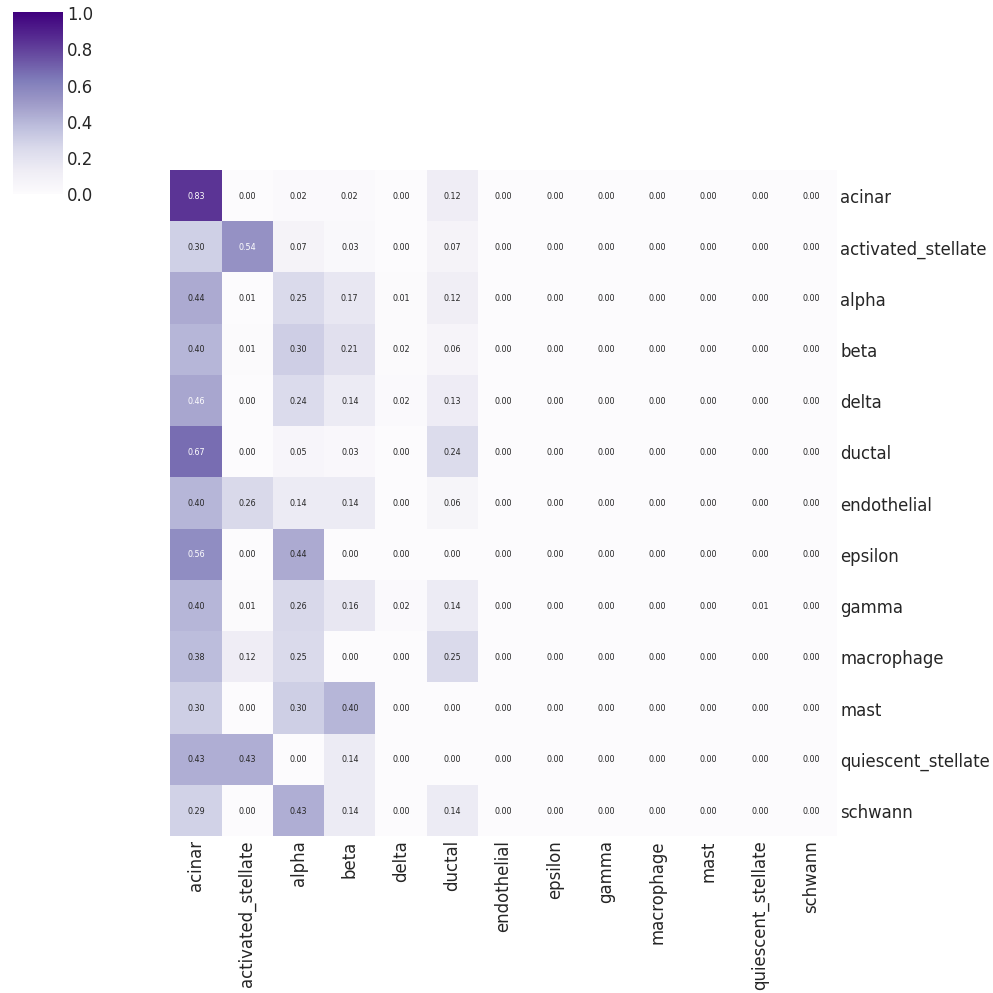

In [27]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

ax = sns.clustermap(df,  
                    cmap='Purples',
                    annot=True ,fmt=".2f", 
                    annot_kws={'size': 8}, 
                    vmin=0, 
                    vmax=1,
                    row_cluster=False, 
                    col_cluster=False, 
                    figsize=(14, 14),
                    )